# Setup and reading in data:

+ split data into test and train with sklearn 
+ test models with sklearn.metrics accuracy_score
+ R2 score for simplest model (horizontal line), RMSE should be way worse for that than the linear fit model. sklearn.metris r2_score


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
# Others here as needed;

In [2]:
# "globals" -- bounding edges of crime in Chicago
lat_min = 41.644604096
lat_max = 42.022671246
lon_min = -87.928909442 
lon_max = -87.524529378

In [3]:
# Read in new da
vacant_df = pd.read_csv("data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv")
health_df = pd.read_csv("data/Chicago_Department_of_Public_Health_Clinic_Locations.csv")
connect_df = pd.read_csv("data/Connect_Chicago_Locations.csv") # internet access
bus_df = pd.read_csv("data/CTA_-_System_Information_-_Bus_Stop_Locations_in_Digital_Sign_Project.csv")
train_df = pd.read_csv("data/CTA_-_System_Information_-_List_of__L__Stops.csv")
farmer_df = pd.read_csv("data/Farmers_Markets_-_2012.csv")
library_df = pd.read_csv("data/Libraries_-_Locations__Hours_and_Contact_Information.csv")
police_df = pd.read_csv("data/Police_Stations_Map.csv")
crime_df = pd.read_csv("data/Chicago_Crimes_2012_to_2017.csv")

/Users/jacob/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Crime dataset is quite large, so we'll only focus on last year:
crime_df = crime_df[crime_df["Year"] == 2016]

# Convert the string dates to datetime objects
crime_df["Date"] = pd.to_datetime(crime_df["Date"])

In [5]:
# Let's add a column that is 0-366 range, this will allow us to look at time slices throughout 2016
crime_df["Day"] = crime_df["Date"].apply(lambda x: x.timetuple().tm_yday)

In [6]:
# Let's pick a week long period to look a

In [7]:
# Let's pick a good 

In [8]:
def location_converter(s):
    """Takes a series of points -- tuples (lat, lon) --  as strings and converts them to floats"""
    return s.apply(lambda x: tuple(float(x) for x in x.strip(')(').replace(',','').split()))

# Not all DFs had the same keyname for the lat/lon points. Now they'll all be converted
# in to simple series of tuples. 
vacant_locations = location_converter(vacant_df["Location"].dropna())
health_locations = location_converter(health_df["Location"].dropna())
connect_locations = location_converter(connect_df["Location"].dropna())
bus_locations = location_converter(bus_df["Location"].dropna())
train_locations = location_converter(train_df["Location"].dropna())
farmer_locations = location_converter(farmer_df["Map"].dropna())
library_locations = location_converter(library_df["LOCATION"].dropna())
police_locations = location_converter(police_df["LOCATION"].dropna())

In [9]:
crime_week_df = crime_df[(crime_df["Day"] >= 100) & (crime_df["Day"] <= 107)]
crime_week_locations = location_converter(crime_week_df["Location"].dropna())
#crime_df.columns


In [10]:
def make_grid(m1, m2, bandwidth):
    """ Returns a 200 x 200 grid of the chica"""
    X, Y = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j] # make a mesh grid of the values 100 x 100
    # this grid is from min to max with nj being the step size.  X/Y are 30x30 for the steps between min and max

    positions = np.vstack([X.ravel(), Y.ravel()]) # x row vector on top of y row vector, complete space
    values = np.vstack([m1, m2]) # raw data lat/lon for 23 stations
    kernel = stats.gaussian_kde(values, bw_method=bandwidth)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [11]:
vacant_grid = make_grid([lat for lat,_ in vacant_locations], [lon for _,lon in vacant_locations], 0.26)
health_grid = make_grid([lat for lat,_ in health_locations], [lon for _,lon in health_locations], 0.26)
connect_grid = make_grid([lat for lat,_ in connect_locations], [lon for _,lon in connect_locations], 0.26)
bus_grid = make_grid([lat for lat,_ in bus_locations], [lon for _,lon in bus_locations], 0.26)
train_grid = make_grid([lat for lat,_ in train_locations], [lon for _,lon in train_locations], 0.26)
farmer_grid = make_grid([lat for lat,_ in farmer_locations], [lon for _,lon in farmer_locations], 0.26)
library_grid = make_grid([lat for lat,_ in library_locations], [lon for _,lon in library_locations], 0.26)
police_grid = make_grid([lat for lat,_ in police_locations], [lon for _,lon in police_locations], 0.26)
crime_week_grid = make_grid([lat for lat,_ in crime_week_locations], [lon for _,lon in crime_week_locations], 0.26)

In [12]:
def plot_grid(grid, locations):
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(grid), cmap=plt.cm.gist_earth_r, extent=[lat_min, lat_max, lon_min, lon_max])
    ax.plot([lat for lat,_ in locations], [lon for _,lon in locations], 'k.', markersize=3)
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([lon_min, lon_max])
    plt.show()

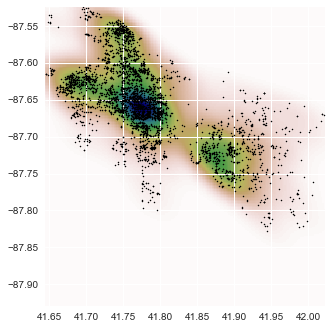

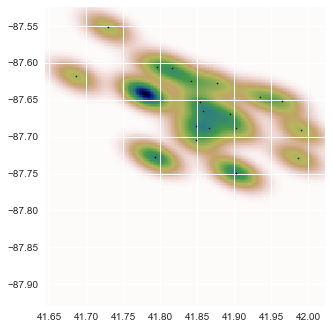

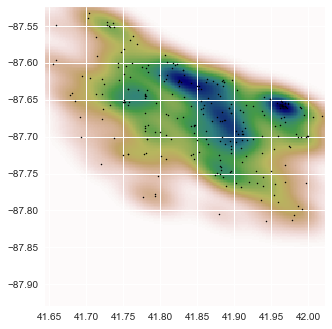

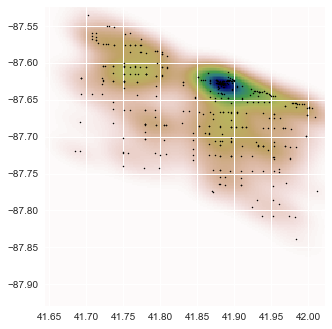

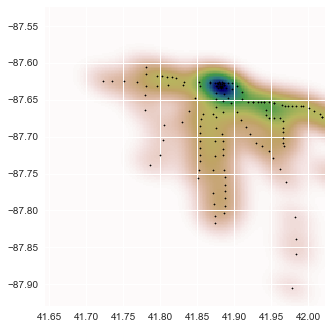

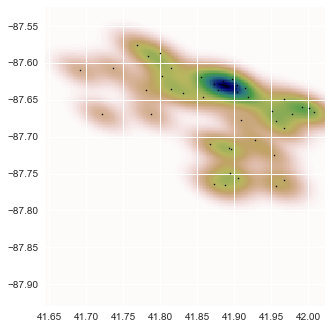

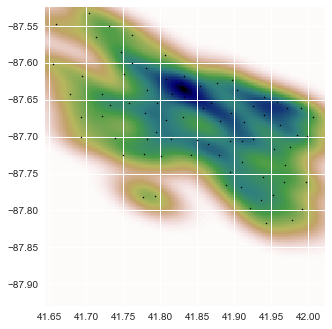

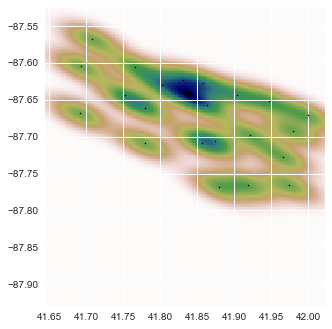

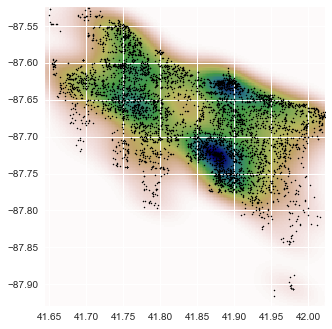

In [13]:
plot_grid(vacant_grid, vacant_locations[:4000]) # too many vacant lots to show all, good 
plot_grid(health_grid, health_locations)
plot_grid(connect_grid, connect_locations)
plot_grid(bus_grid, bus_locations)
plot_grid(train_grid, train_locations)
plot_grid(farmer_grid, farmer_locations)
plot_grid(library_grid, library_locations)
plot_grid(police_grid, police_locations)
plot_grid(crime_week_grid, crime_week_locations)

In [32]:
# Turn the grids into vectors:
vacant_vector = vacant_grid.flatten()
health_vector = health_grid.flatten()
connect_vector = connect_grid.flatten()
bus_vector = bus_grid.flatten()
train_vector = train_grid.flatten()
farmer_vector = farmer_grid.flatten()
library_vector = library_grid.flatten()
police_vector = police_grid.flatten()
crime_week_vector = crime_week_grid.flatten()

# Make a dataframe with the flattened vectors for input to ML algorithms:
grid_df = pd.DataFrame({"Vacant lots" : vacant_vector, "Health clinics" : health_vector, 
                        "Connect hotspots": connect_vector, "Bus stops" : bus_vector, 
                        "Train stops" : train_vector, "Farmers markets": farmer_vector, 
                        "Libraries": library_vector, "Police stations": police_vector})

In [29]:
# Slooow: 
g = sns.pairplot(grid_df, kind="reg")

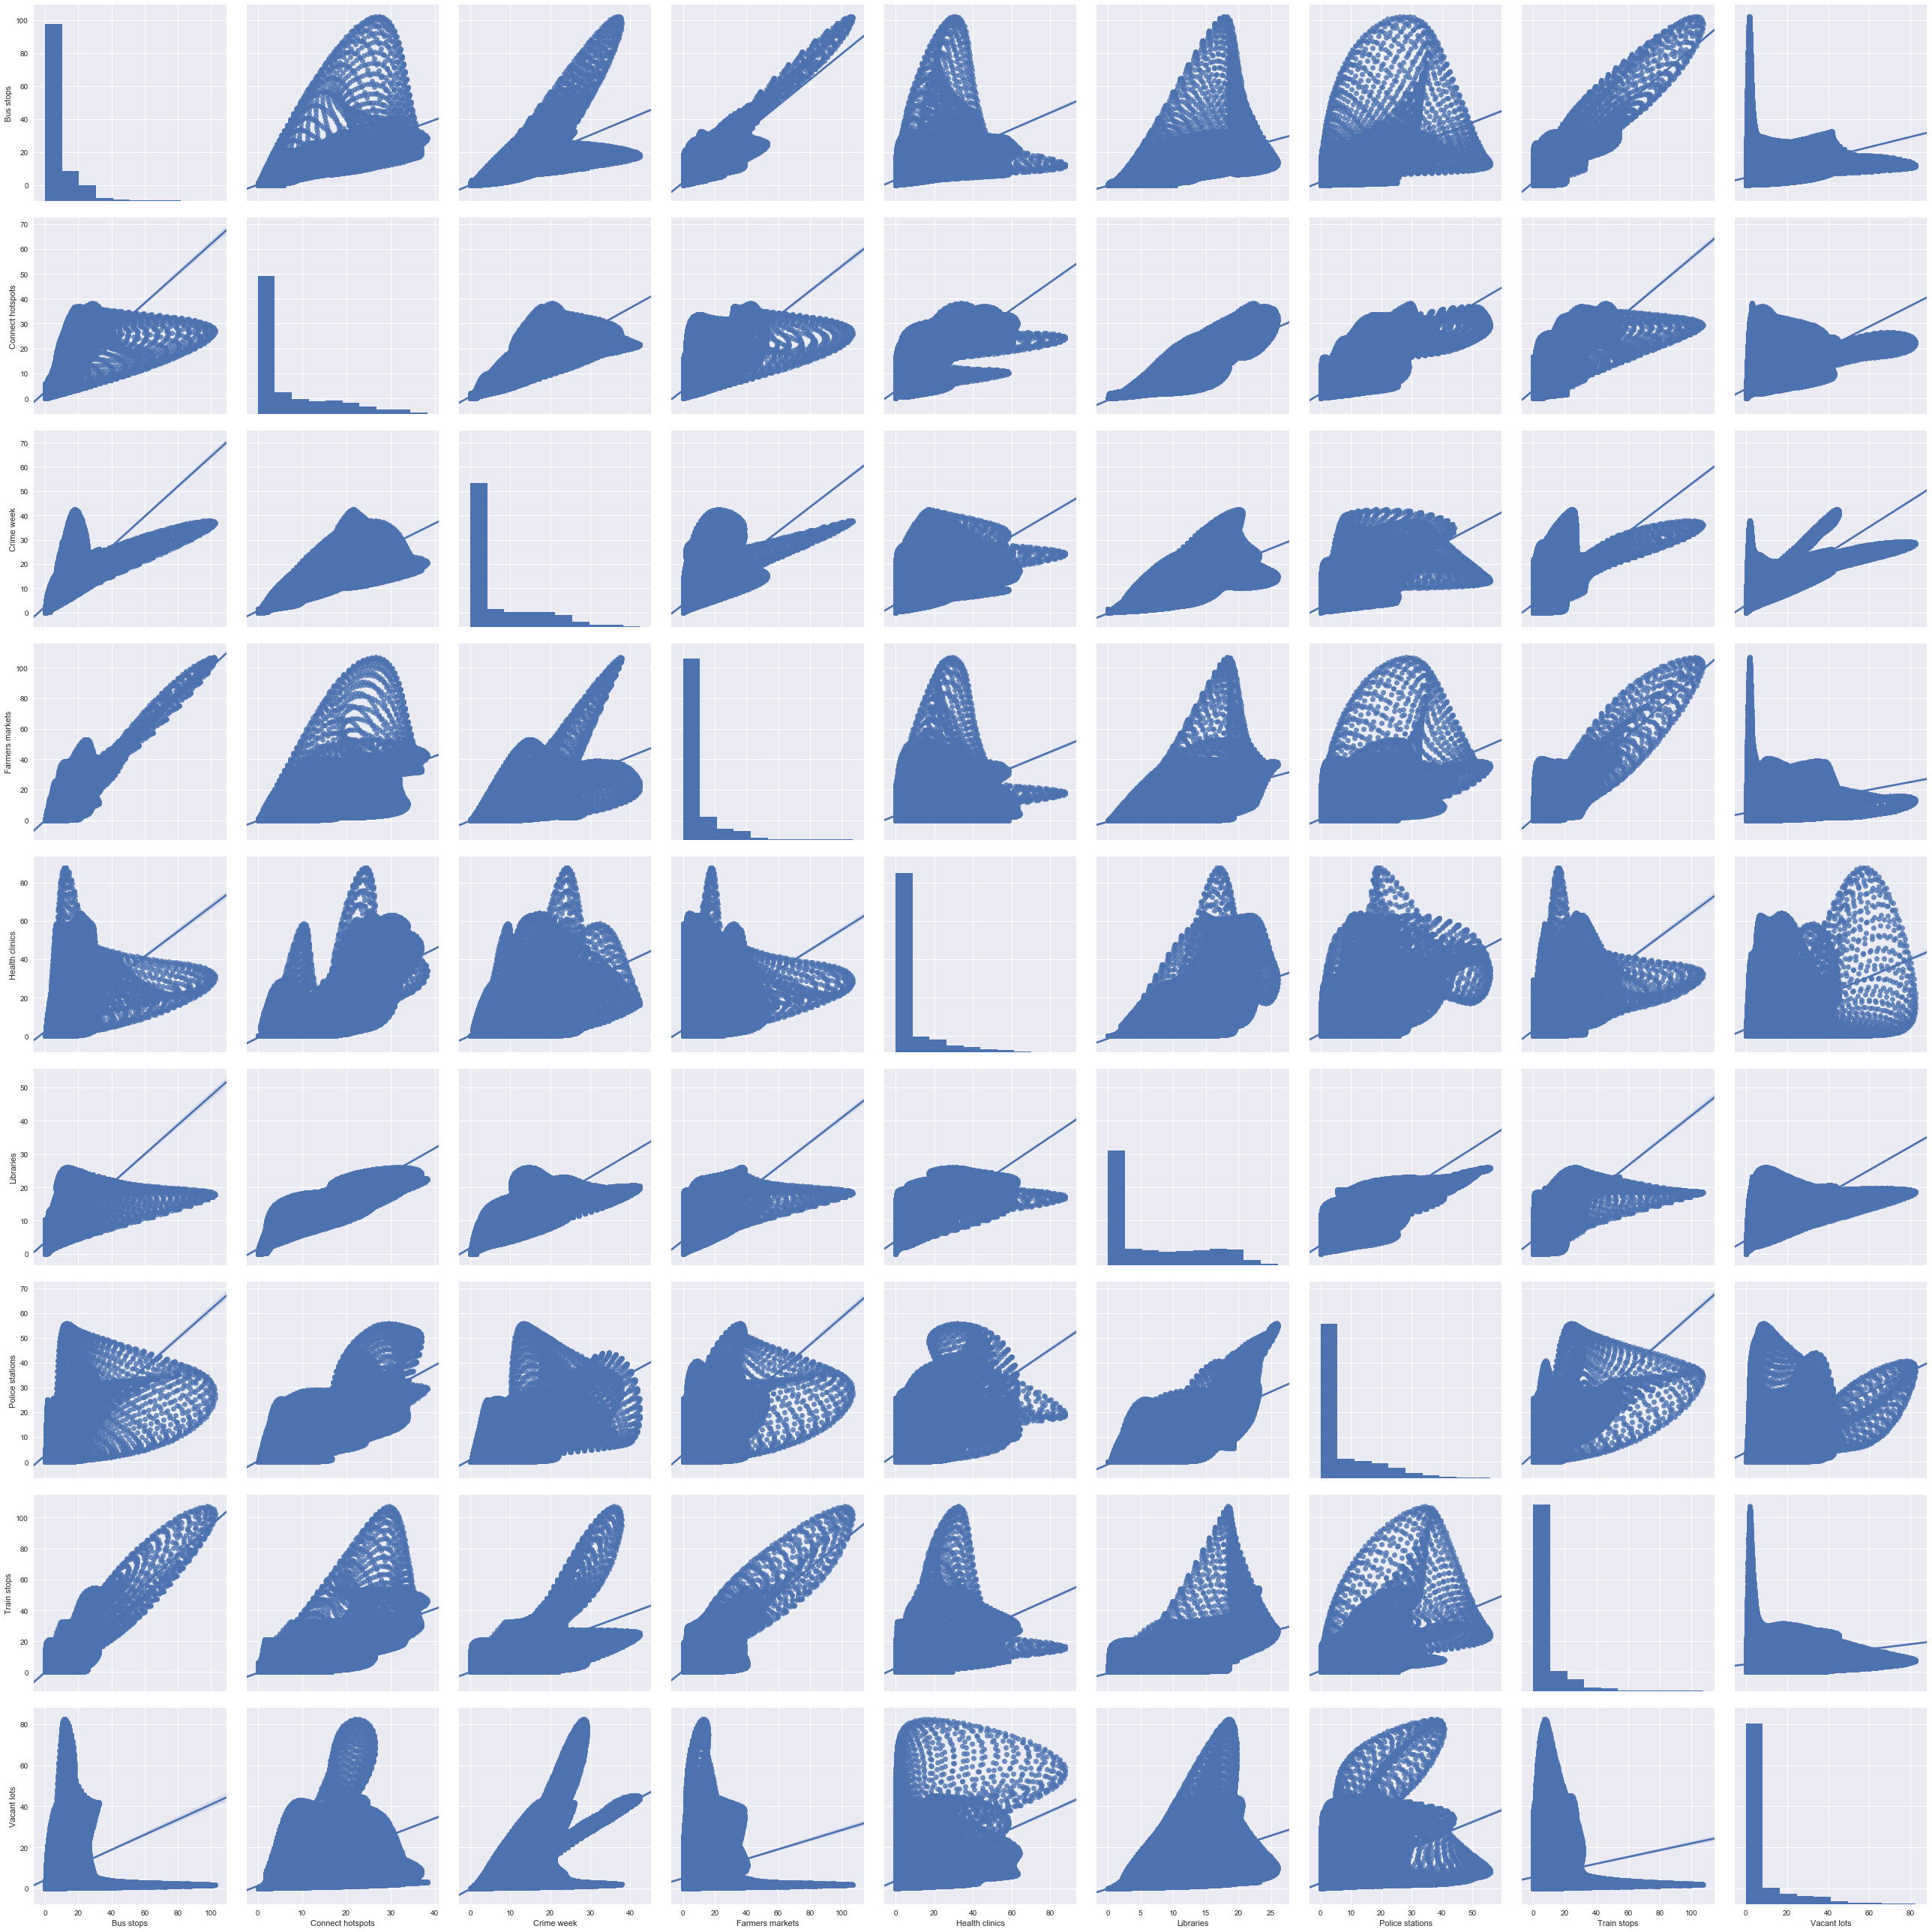

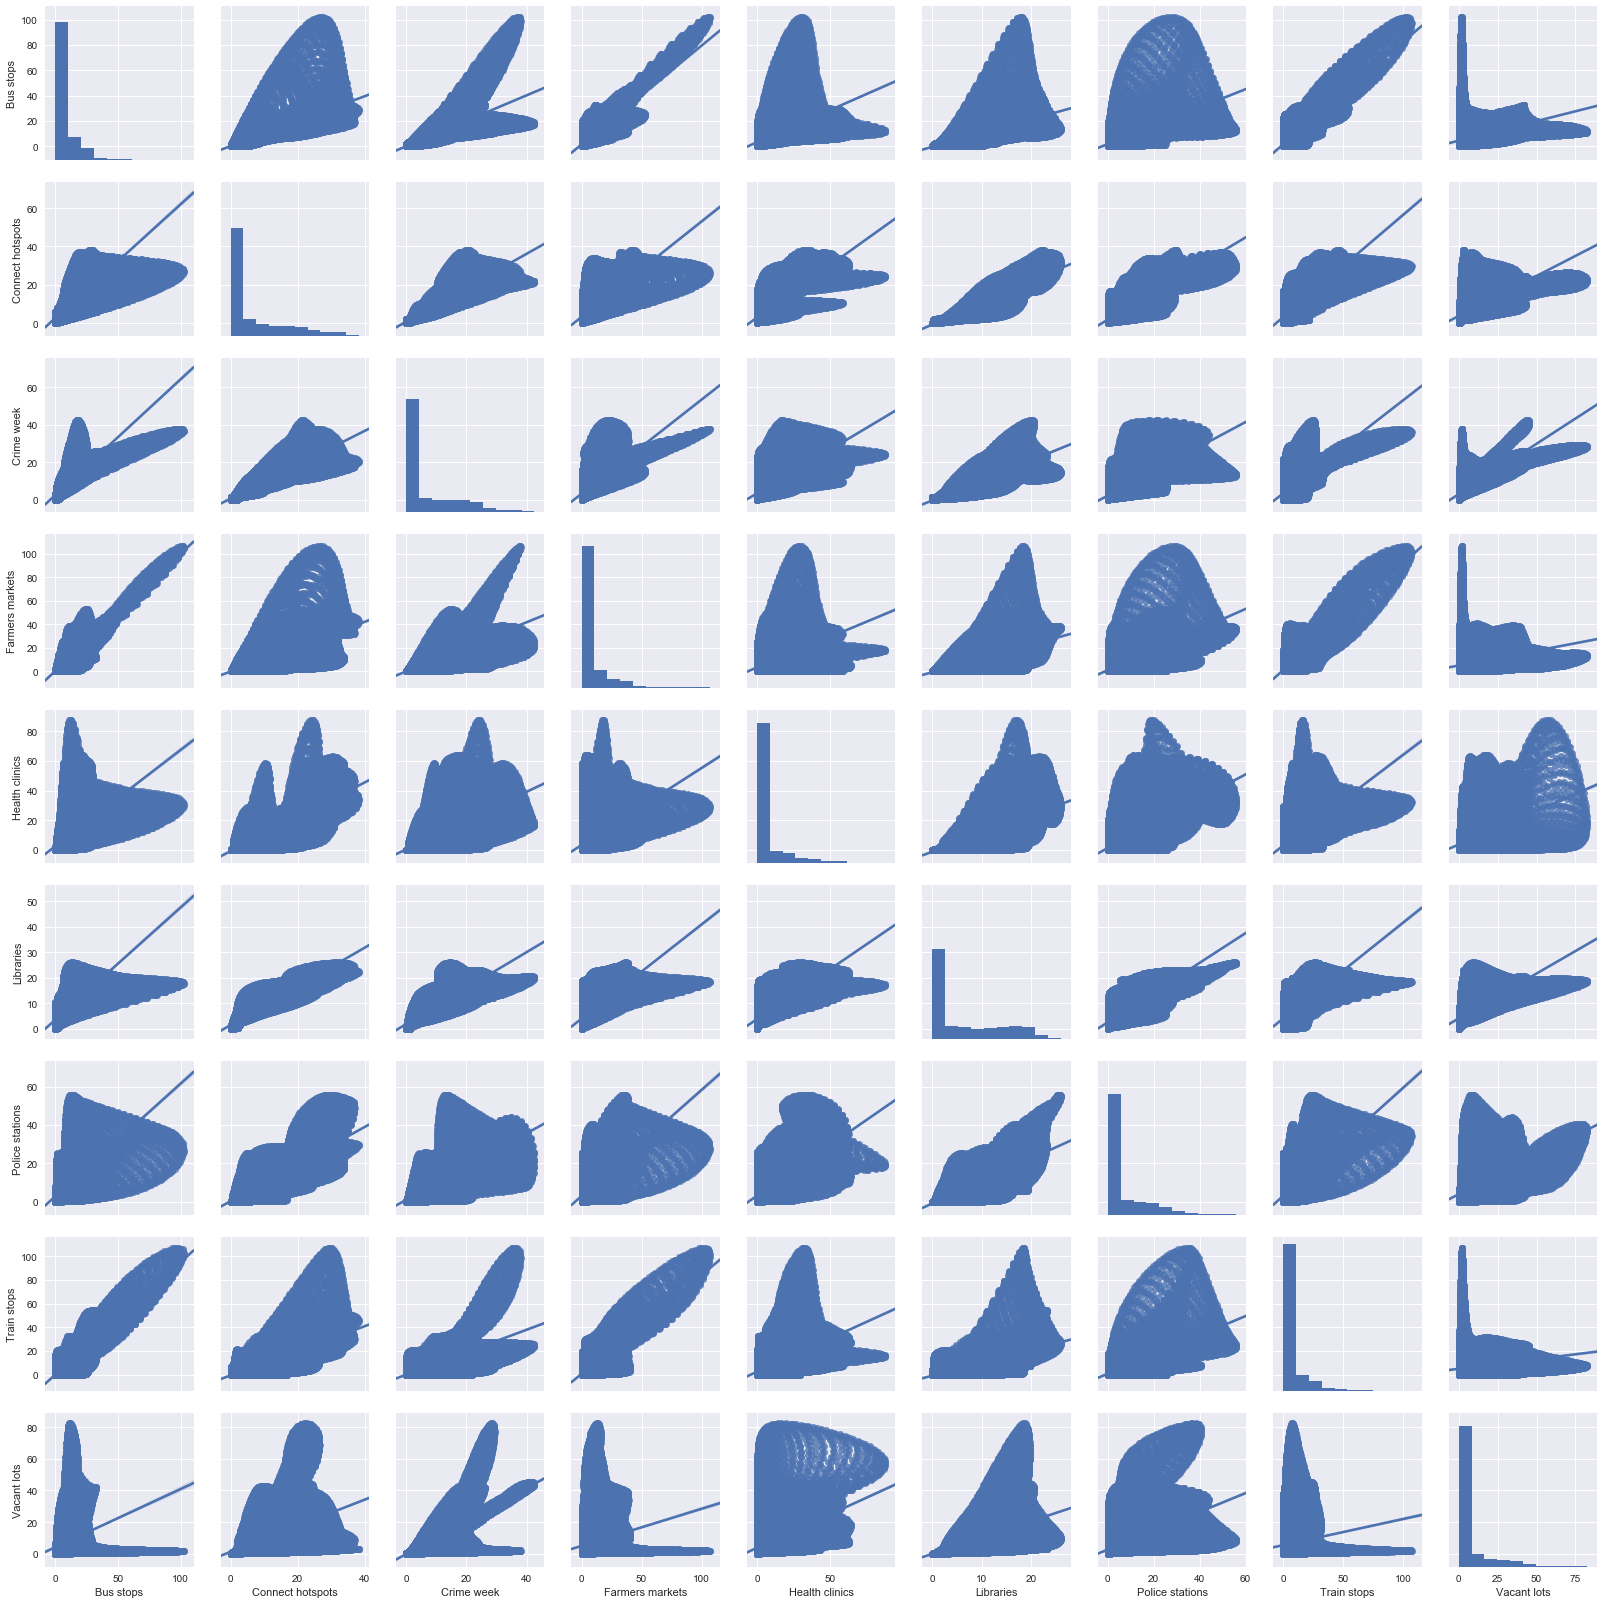

In [31]:
plt.show(g)

# Fitting models

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score # For comparisons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [35]:
# Get test and training sets 20% saved for testing:
X_train, X_test, y_train, y_test = train_test_split(grid_df, crime_week_vector, test_size=0.2) 

In [87]:
#X_test["Police stations"].shape
X_test["Police stations"].values.shape

(8000, 1)

## Create a baseline by performing regression with a single feature:

In [111]:
base_linear_classifier = LinearRegression()
base_linear_classifier.fit(X_train["Police stations"].values.reshape(-1, 1), y_train)
base_linear_guesses = linear_classifier.predict(X_test["Police stations"].values.reshape(-1,1))
base_linear_error = mean_squared_error(y_test, base_linear_guesses)
base_linear_r2 = r2_score(y_test, base_linear_guesses)
base_linear_error, base_linear_r2

ValueError: shapes (8000,1) and (8,) not aligned: 1 (dim 1) != 8 (dim 0)

## Linear regression with multiple features:

In [43]:
# Linear regression:
linear_classifier = LinearRegression()
linear_classifier.fit(X_train, y_train)
linear_guesses = linear_classifier.predict(X_test)
linear_error = mean_squared_error(y_test, linear_guesses)
linear_r2 = r2_score(y_test, linear_guesses)

In [44]:
linear_error, linear_r2 # R2 is in units of the dependant variable. 

(4.7154874564442384, 0.94175401136282022)

In [ ]:
#

## SVM:

In [104]:
from sklearn.svm import SVC
# The following are used to 
from sklearn import preprocessing
from sklearn import utils

In [ ]:
svc = SVC(kernel='linear')

# Properly label encode the float values:
label_encoder = preprocessing.LabelEncoder()
X_train_encoded = X_train.apply(label_encoder.fit_transform) # Must apply to every column
y_train_encoded = label_encoder.fit_transform(y_train)

svc.fit(X_train_encoded, y_train_encoded)

In [100]:
X_train.values


array([[  6.52864381e+00,   9.46871602e+00,   2.76682623e-01, ...,
          1.97233028e+01,   9.48825222e-01,   1.02475469e+01],
       [  7.61858790e+00,   9.83067162e+00,   1.98713383e+00, ...,
          1.18231159e+01,   5.57577973e-01,   1.99178931e+01],
       [  2.01914984e+01,   1.71183507e+01,   3.21858911e+01, ...,
          8.38637174e+00,   2.35021502e+01,   1.14048322e+00],
       ..., 
       [  1.77236194e+01,   1.04079996e+01,   1.28846363e+01, ...,
          1.53815623e+01,   6.40111737e+00,   2.10554050e+01],
       [  1.72745047e+01,   1.11754700e+01,   4.01397320e+01, ...,
          9.98081837e+00,   2.75258539e+01,   9.94908100e-01],
       [  1.67090726e-26,   3.58678083e-13,   1.05491177e-36, ...,
          6.02529638e-39,   3.39376651e-13,   1.31236073e-12]])

In [106]:
t = y_train[0:5].astype('int')
t

array([ 9, 11,  9,  0,  0])

In [107]:
y_train[0:5]

array([  9.55992441e+00,   1.18894359e+01,   9.51357877e+00,
         2.93646926e-24,   3.93226732e-04])